In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.fft import fft, ifft, fftfreq
from matplotlib.pyplot import figure
import cmath
import math
import pandas as pd

In [ ]:
#FDTD 10-ring crow structure containing 24 segments - the 4 extra segments correspond to the input and output waveguides (2 each).

NUM_PORTS = 4
SIZE = 200
imp0 = 377
connect = 50
tau = 0.3
kappa = 0.5 # not working yet for complex number
kappa_x = 0
kappa_y = 0.5
k_complex = complex(kappa_x,kappa_y)
k = abs(k_complex)
k_polar = cmath.polar(k_complex)

maxTime = 2000

N_seg = 24 #will have in total 24 segments

shape = (N_seg,2)
sources = np.zeros(shape)
sources[0][:] = [-1,-1]
print(np.shape(sources))


#making a pattern for sources: [worked so hard on thissss!]
for i in range(int(N_seg/2)):
    sources[(2*i+1)][0] = 2*i  #t couplings
    if i<11:
        sources[(2*i+2)][0] = (2*i) + 3  #t couplings for the next segment
    if i%2 == 0: 
        sources[(2*i+1)][1] = sources[(2*i+1)][0] + 2
        if i<10:
            sources[(2*i+2)][1] = sources[(2*i+2)][0] + 2
        else:
            sources[(2*i+2)][1] = sources[(2*i+2)][0] -2  #exception for the last segment
    else:
        sources[(2*i+1)][1] = sources[(2*i+1)][0] - 2
        if i<11:
            sources[(2*i+2)][1] = sources[(2*i+2)][0] - 2

        
sources = sources.astype(int)
print(sources)
#sources = [[-1,-1],[0,2],[3,5],[2,0],[5,3],[2,4]]
couplings = np.zeros(shape)
couplings[:][:] = [tau, k]
# couplings[0][:] = [-1,-1]
# couplings[1:N_seg][:] = [tau,kappa]
print(np.shape(couplings))
# print(couplings)

ez_tab = np.zeros([N_seg, maxTime, SIZE])

(24, 2)
[[-1 -1]
 [ 0  2]
 [ 3  5]
 [ 2  0]
 [ 5  3]
 [ 4  6]
 [ 7  9]
 [ 6  4]
 [ 9  7]
 [ 8 10]
 [11 13]
 [10  8]
 [13 11]
 [12 14]
 [15 17]
 [14 12]
 [17 15]
 [16 18]
 [19 21]
 [18 16]
 [21 19]
 [20 22]
 [23 21]
 [22 20]]
(24, 2)


In [58]:
#Trying to use complex numbers - will try and use cmath since it defines both real and imag parts separately and also has a function to find the phase
kappa_x = 0
kappa_y = 0.5
k_complex = complex(kappa_x,kappa_y)
k_polar = cmath.polar(k_complex)
print(k_polar)

(0.5, 1.5707963267948966)


In [73]:
def gaussian(qTime):
    return np.exp(-(qTime - 30.) * (qTime - 30.) / 100.) /imp0

def cw(Time):
    return np.exp(-(Time - 30.) * (Time - 30.) / 100000000.) /imp0

def cosMod(qTime):
    dt = 10e-17  # Time step (s) //added
    t = qTime * dt
    A = 1
    f0 = 300e12
    t0 = 4 * dt * maxTime / 50  # Center time
    tau = 2 * dt * maxTime / 100 # Width
    source = A * np.cos(2 * np.pi * f0 * (t - t0)) * np.exp(-((t - t0)**2) / (tau**2))
    return source

In [74]:
# #Test Source - not needed for the actual program
# N_time = 2000
# dt = 10e-17  # Time step (s)
# t = np.arange(N_time) * dt
# xf = fftfreq(N_time,dt)

# # Pulse parameters
# A = 1.0
# f0 = 200e12       # 200 THz
# t0 = 12 * dt * N_time / 50  # Center time
# tau = 6 * dt * N_time / 50 # Width

# # Define source
# source = A * np.cos(2 * np.pi * f0 * (t - t0)) * np.exp(-((t - t0)**2) / (tau**2))

# # Plot
# figure(figsize=(30,30))
# plt.subplot(2,1,1)
# plt.plot(t * 1e15, source)
# plt.xlabel("Time (fs)")
# plt.ylabel("Amplitude")
# plt.title("Cosine-modulated Gaussian Pulse")
# plt.grid(True)|
# plt.subplot(2,1,2)
# plt.plot(xf, fft(source))
# plt.show()

In [75]:
class segment:
    def __init__(self, SIZE):
        self.ez = np.zeros([SIZE])
        self.hy = np.zeros([SIZE])
        self.sx = 49
        # self.source = source
        # self.tau = coupling[0]
        # self.kappa = coupling[1]
        
    def hy_update(self):
        self.hy[SIZE-1] = self.hy[SIZE-2] # simple ABC for hy
        for j in range(SIZE-1):
            self.hy[j] = self.hy[j] + (self.ez[j+1] - self.ez[j]) / imp0
            
    def ez_update(self):
        for j in range(1,SIZE):
            self.ez[j] = self.ez[j] + (self.hy[j] - self.hy[j-1]) * imp0
        self.ez[0] = self.ez[1]  # simple ABC for ez

    def hy_sources(self, s, sx):
        self.sx = sx
        self.hy[self.sx] -= s /imp0 
        
    def ez_sources(self, s,sx):   
        self.sx = sx
        self.ez[self.sx] += s      

In [76]:
f_array = []

for ii in range(N_seg):
    f = segment(SIZE)
    f_array.append(f)

for qTime in range(maxTime):
    s = cosMod(qTime)
    
    for ii in range(N_seg):
        s1 = sources[ii][0]
        s2 = sources[ii][1]
        tau_ = couplings[ii][0]
        kappa_ = couplings[ii][1]
       
        if (sources[ii][0] == -1):
            s_new = s
            xs = 50
        else:
            s_new = tau_*f_array[s1].ez[-1] + kappa_*f_array[s2].ez[-1]
            xs = 2 
            
        f_array[ii].hy_update()
        f_array[ii].hy_sources(s_new,xs)
        f_array[ii].ez_update()
        f_array[ii].ez_sources(s_new,xs)

        ez_tab[ii,qTime,:] = f_array[ii].ez[:]   

for ii in range(N_seg):
    filename = f"ez_tab_{ii:04d}.csv"  # e.g., ez_tab_0000.txt, ez_tab_0001.txt, ...
    np.savetxt(filename, ez_tab[ii, :, :], delimiter=",")

        

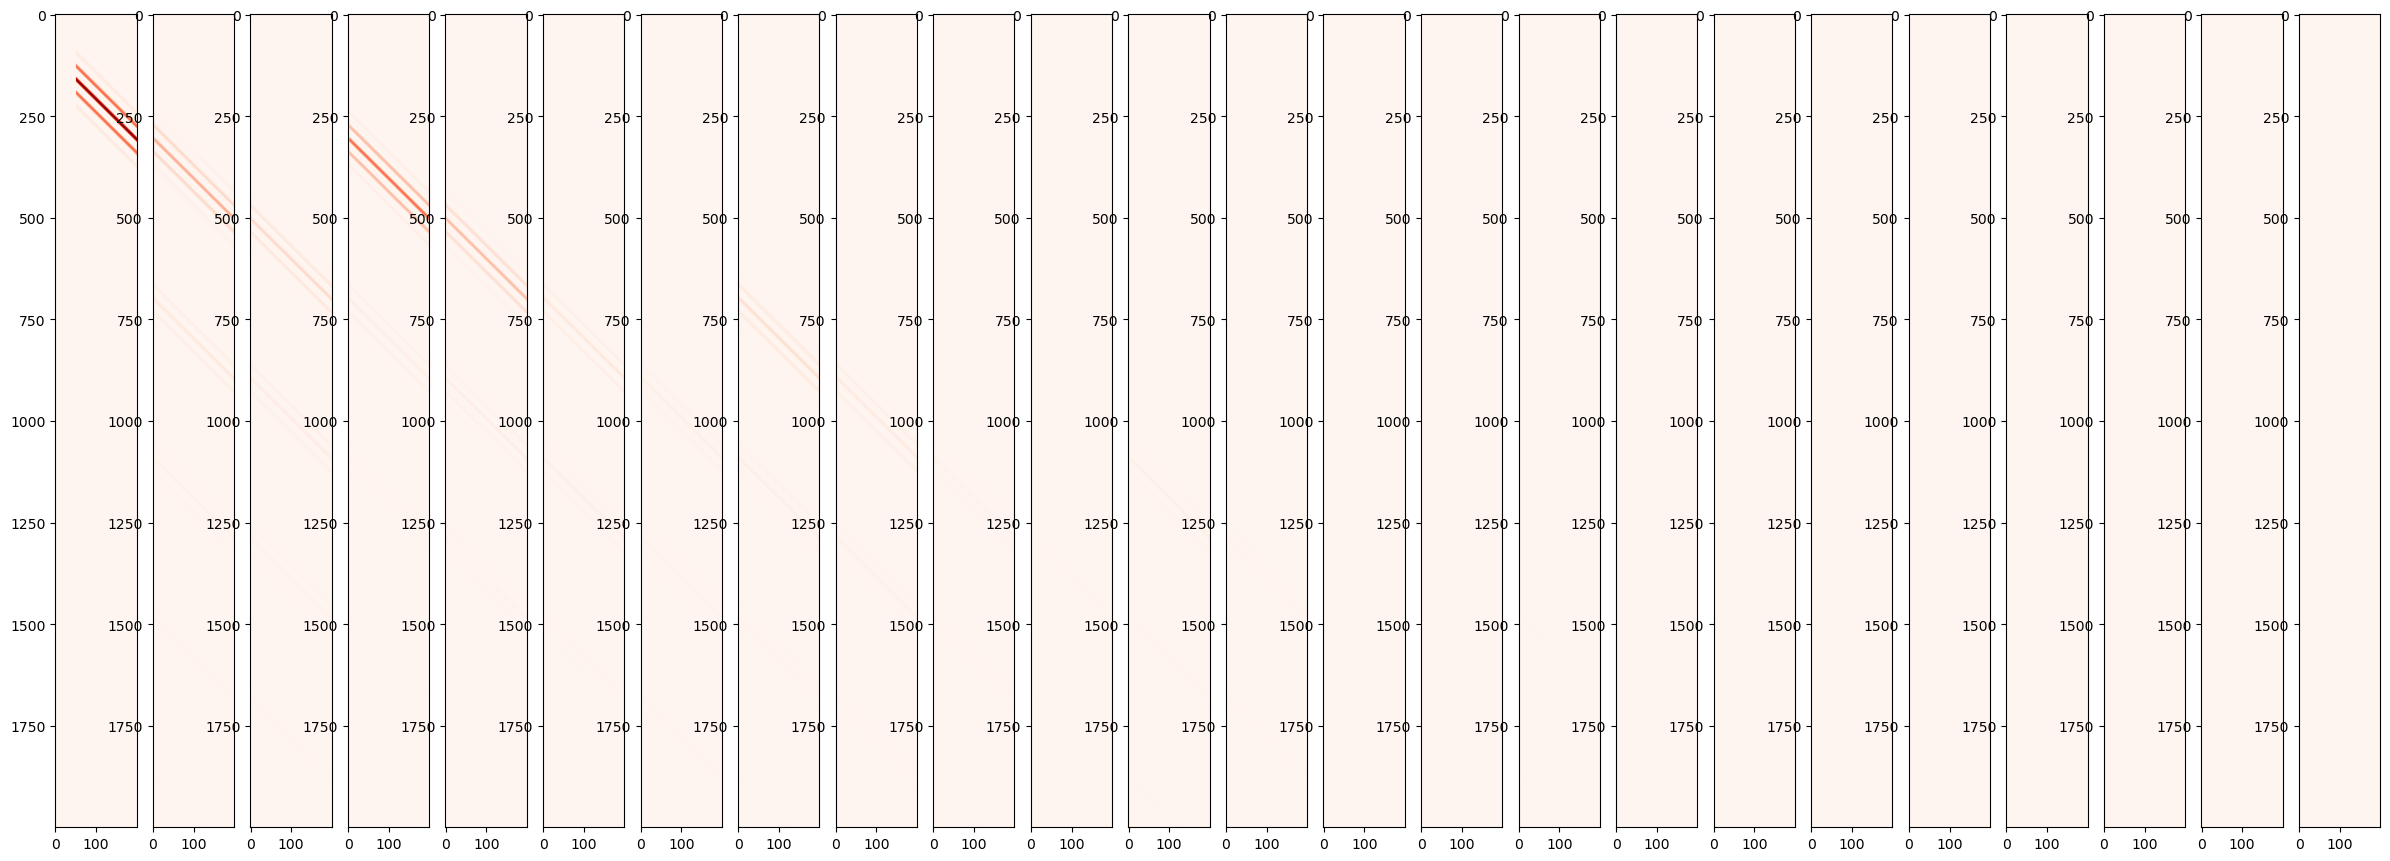

In [77]:
f, ax = plt.subplots(1,N_seg, figsize=(30,40)) 

vmax_val = np.max(ez_tab[0,:,:])

for ii in range(N_seg):
    ax[ii].imshow(ez_tab[ii,:,:], vmin = 0, vmax = vmax_val , cmap = 'Reds')
    # plt.colorbar()
plt.show()

# plt.plot(ez_tab[:,15])

In [78]:
# for ii in range(N_seg):
#     filename = f"ez_tab_{ii:04d}.csv"  # e.g., ez_tab_0000.txt, ez_tab_0001.txt, ...
#     f = open(filename)
#     print(f.readline())

In [79]:
# import csv
# for ii in range(N_seg):
#     filename = f"ez_tab_{ii:04d}.csv"
#     with open(filename) as f:
#         csv_reader = csv.reader(f, delimiter=',')
#         for row in f:
#             print(f.shape)
        
    

range(0, 200)


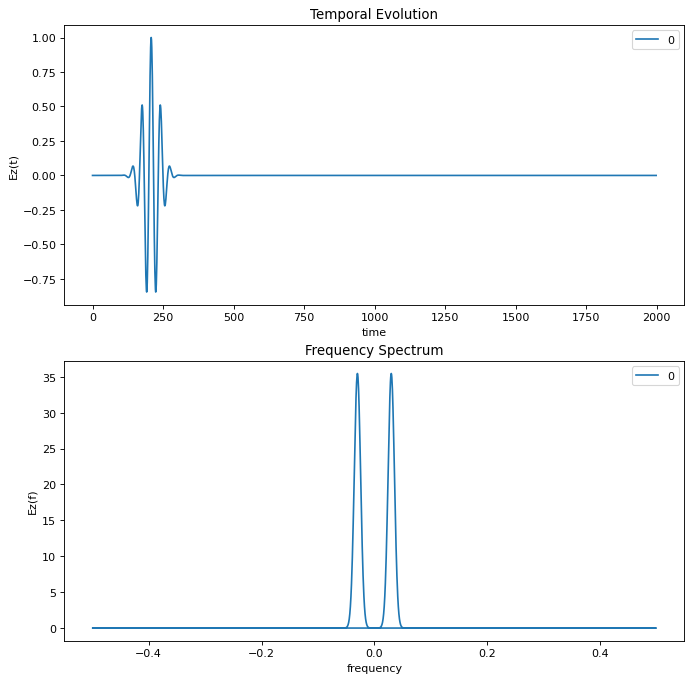

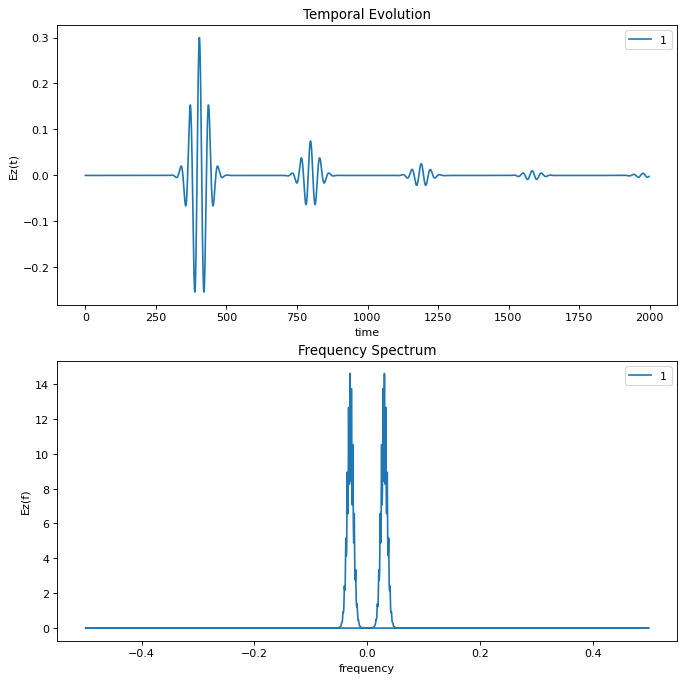

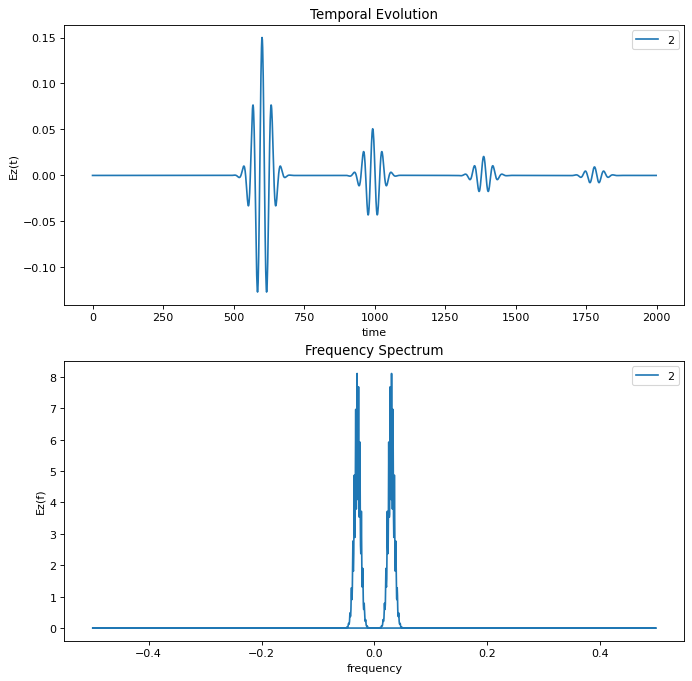

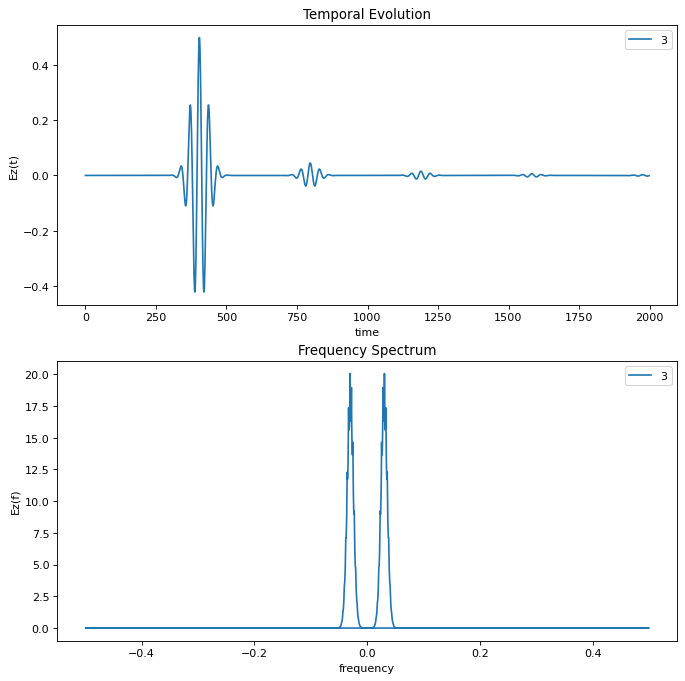

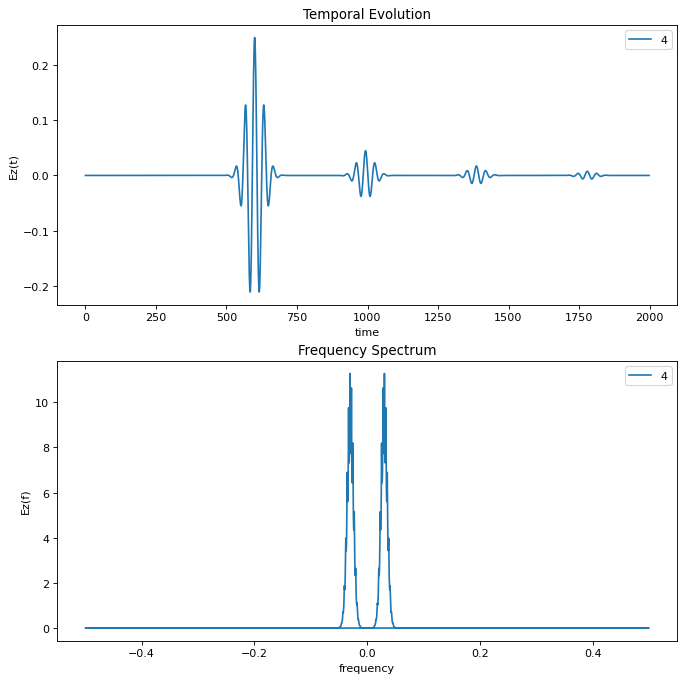

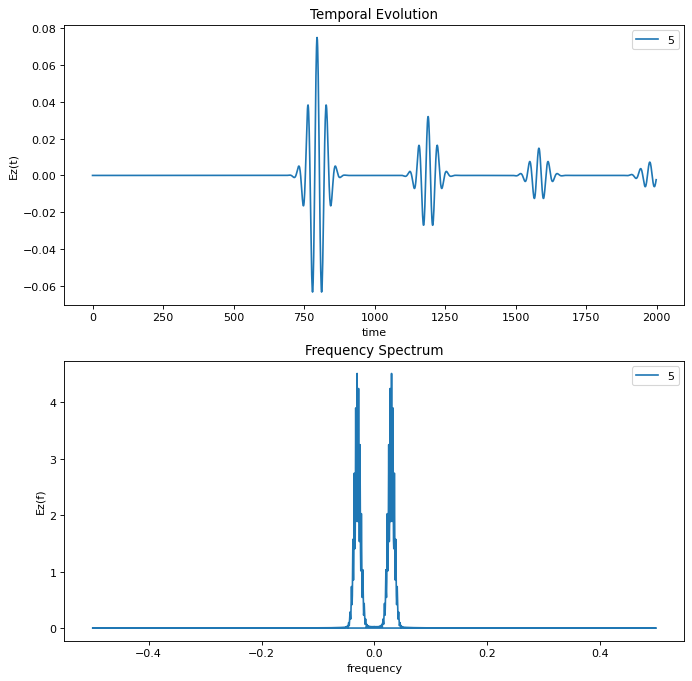

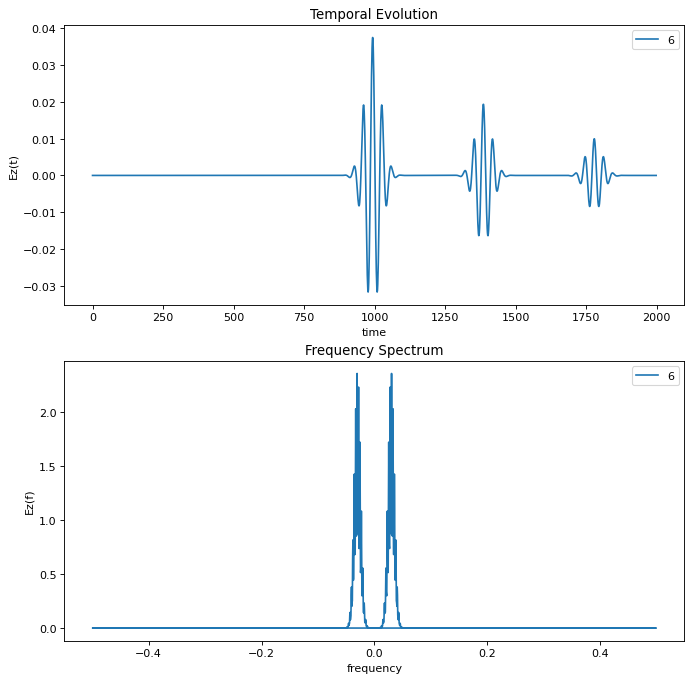

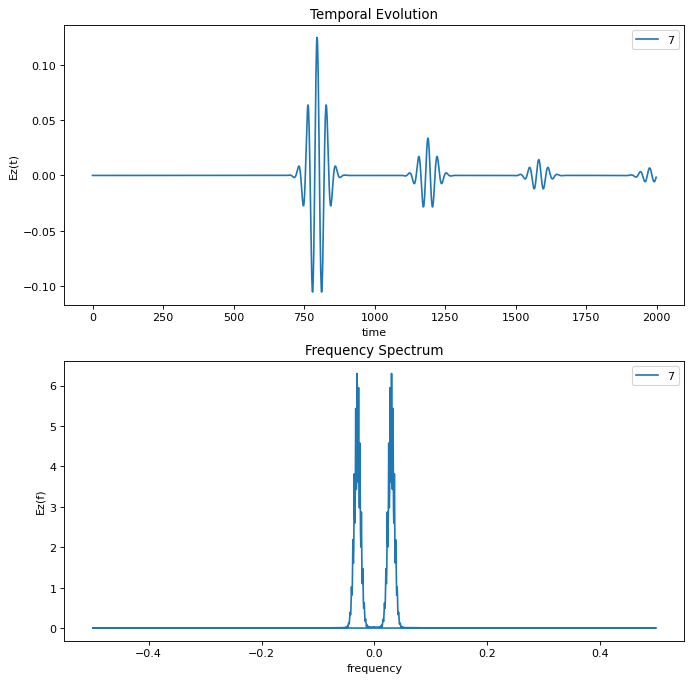

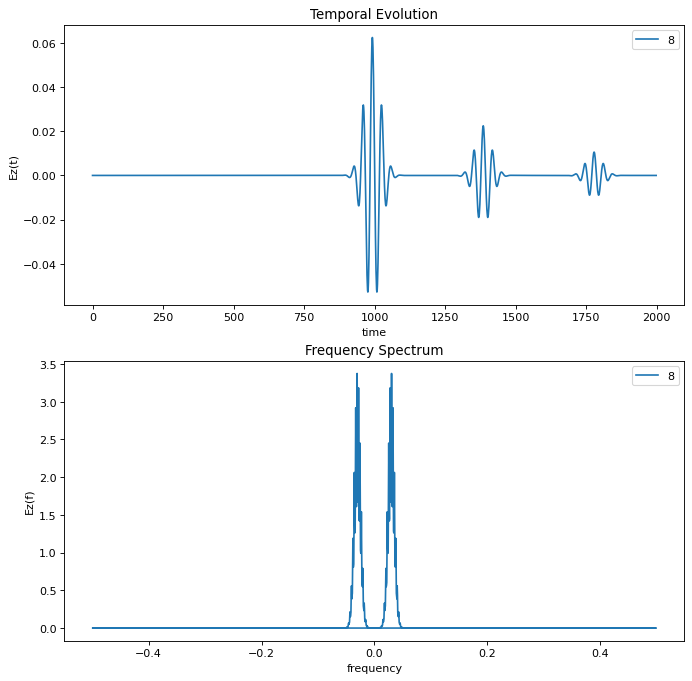

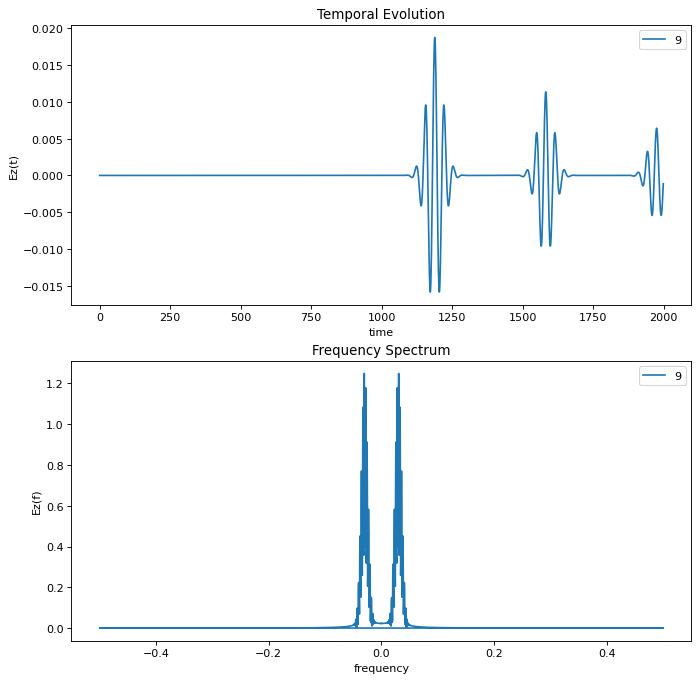

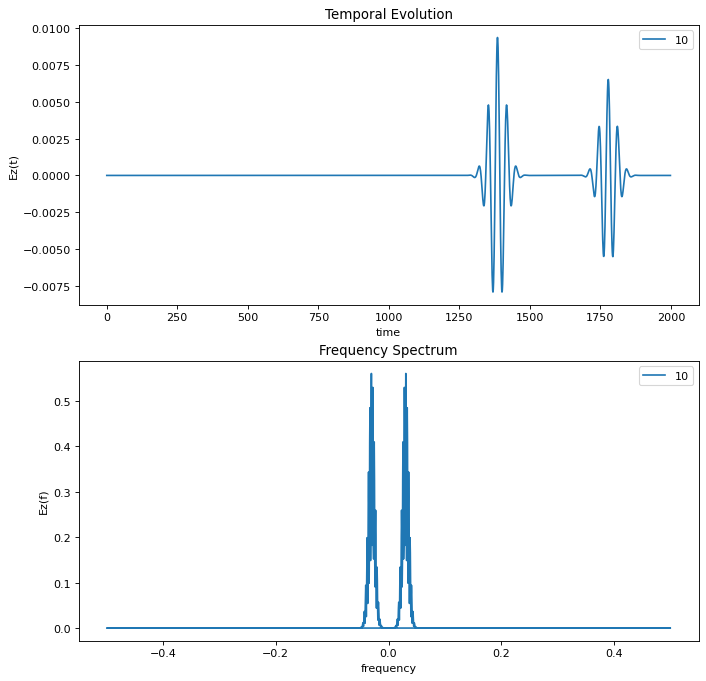

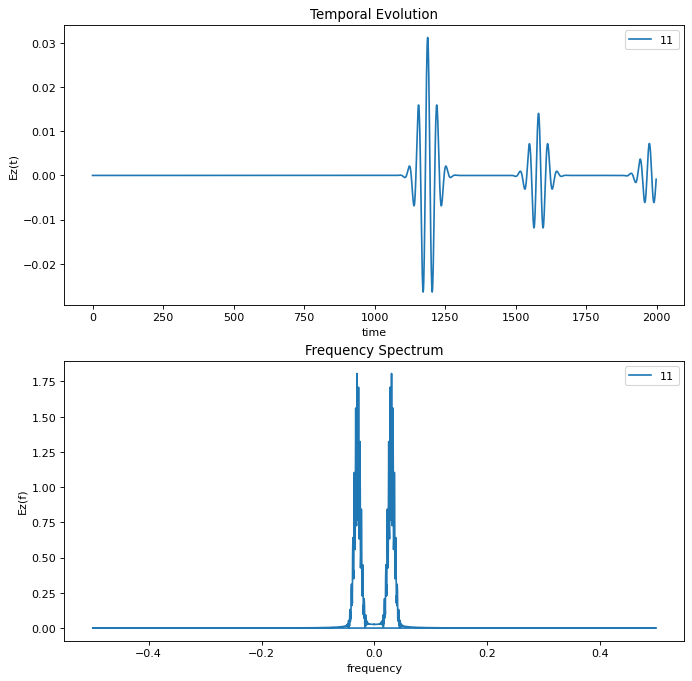

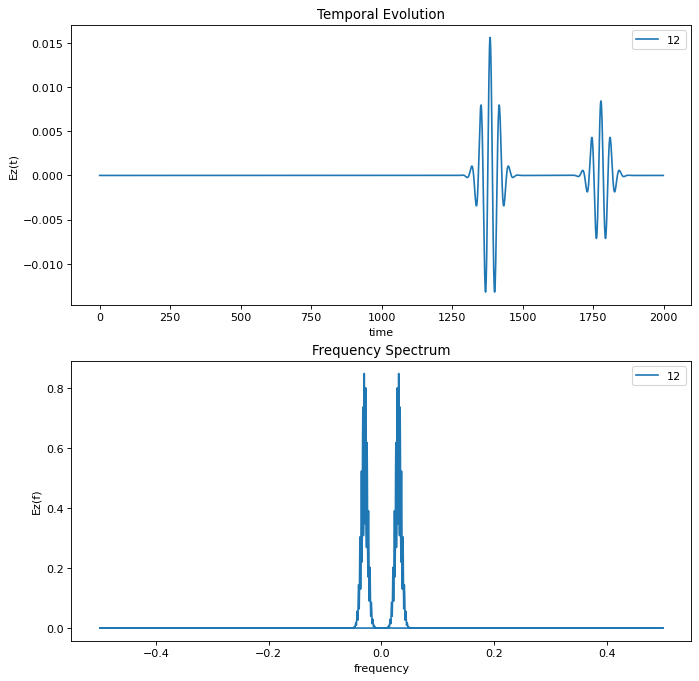

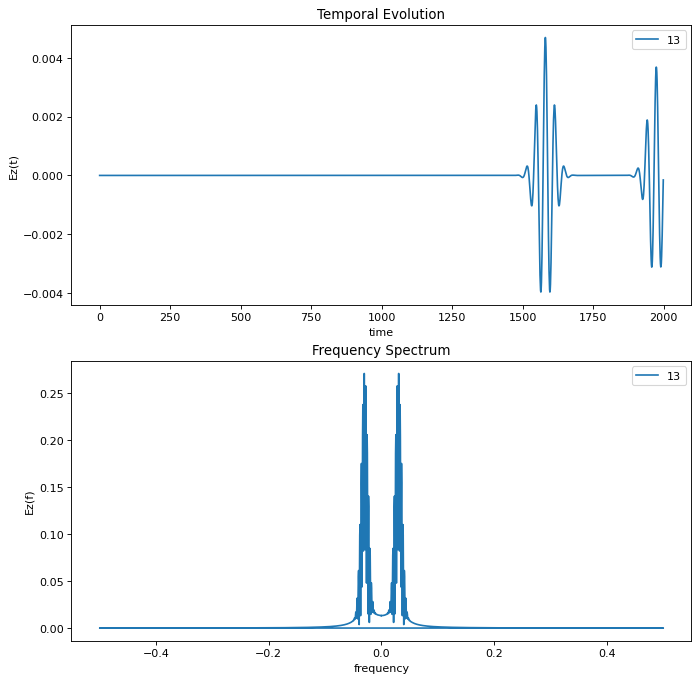

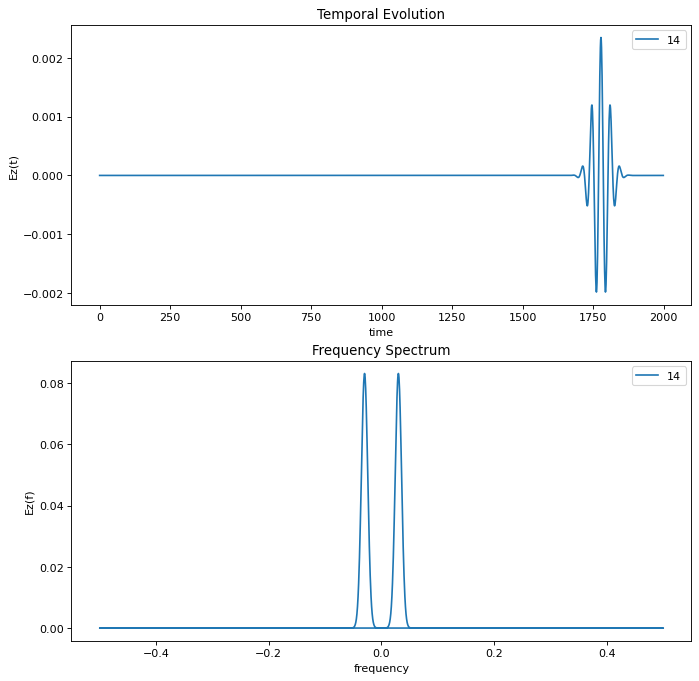

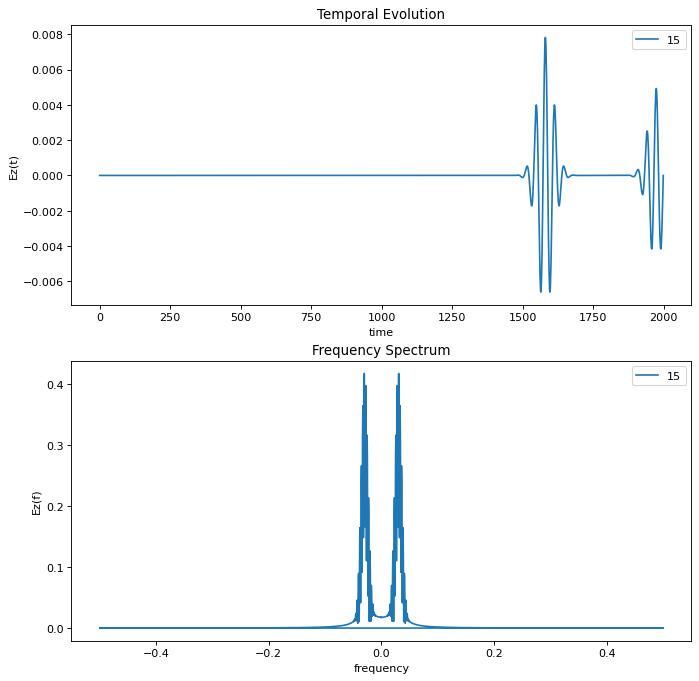

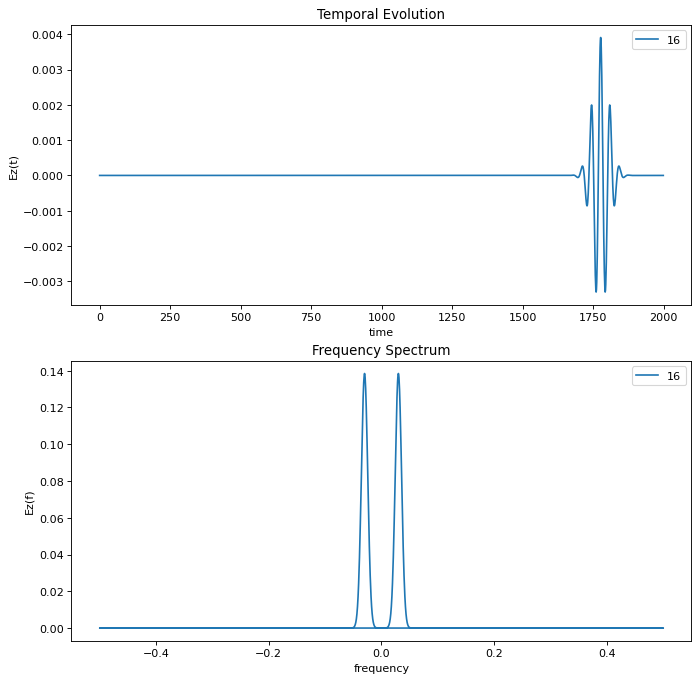

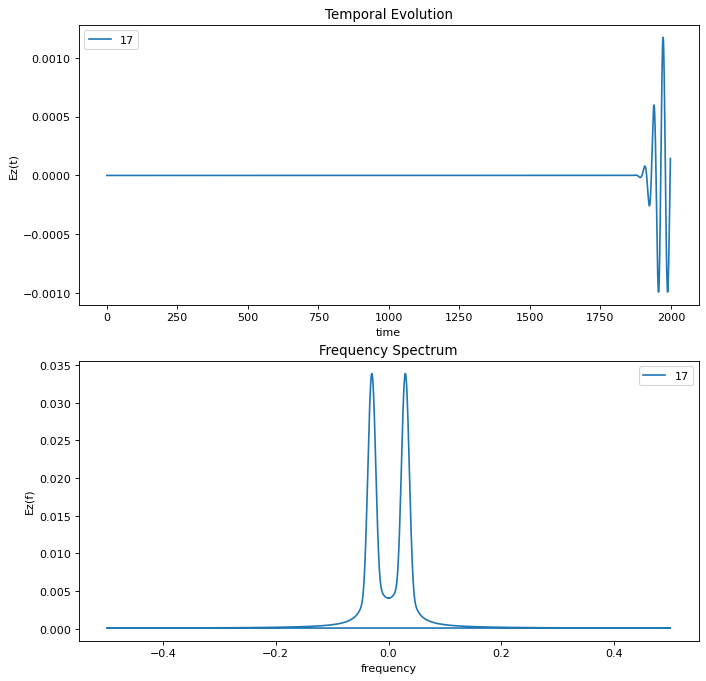

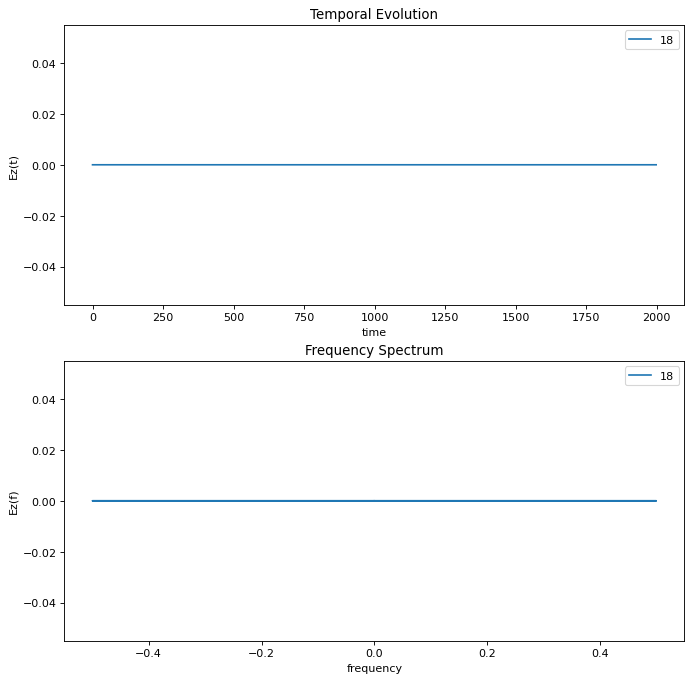

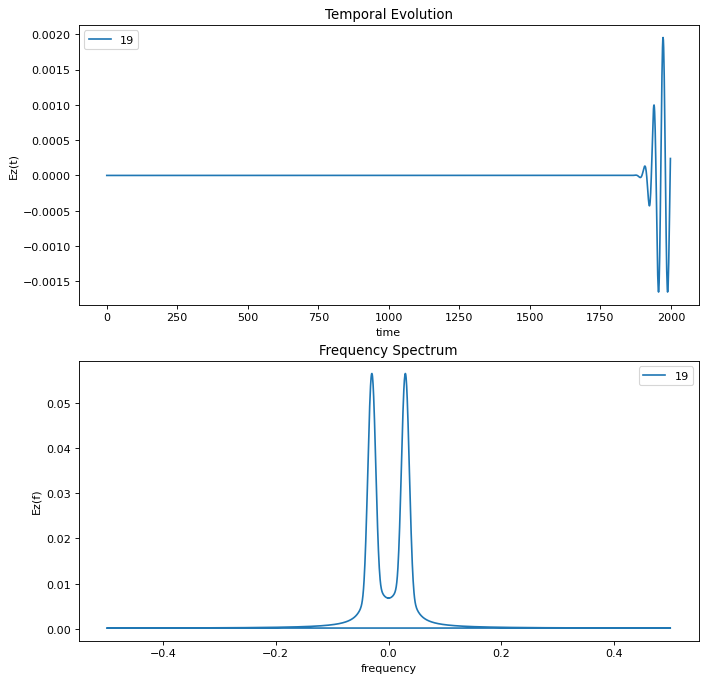

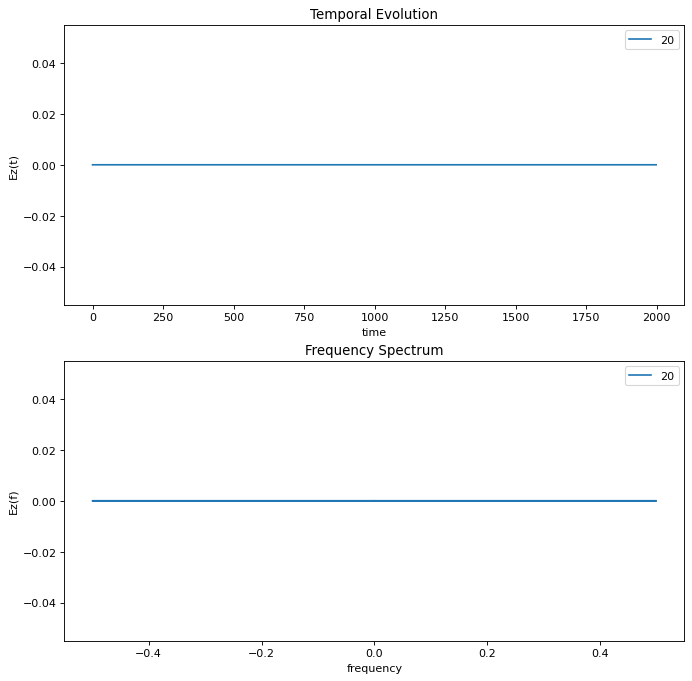

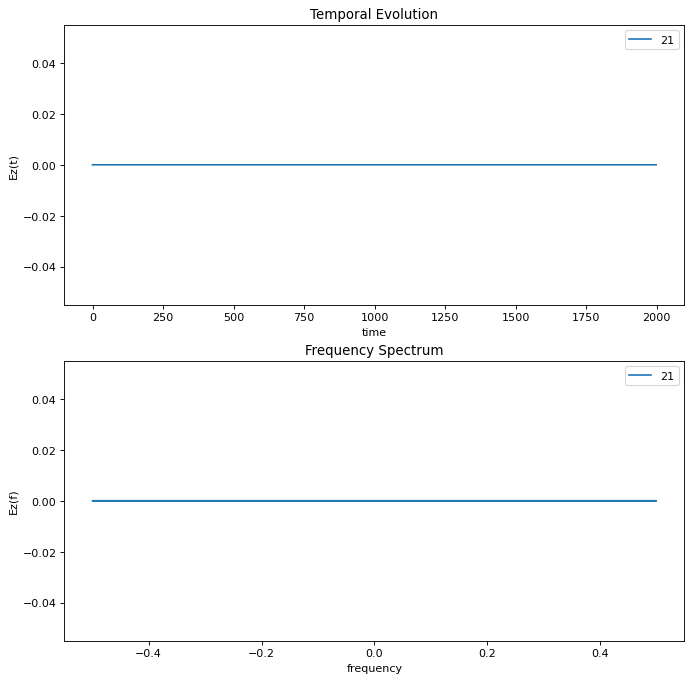

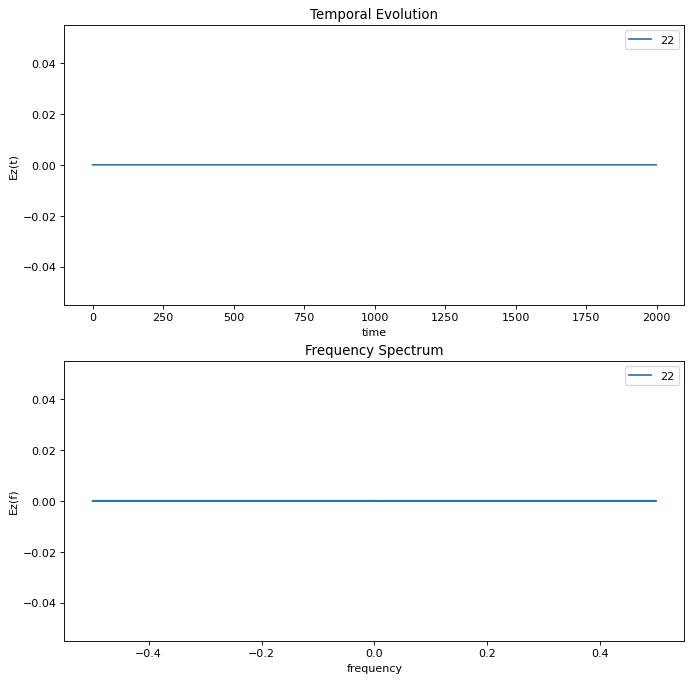

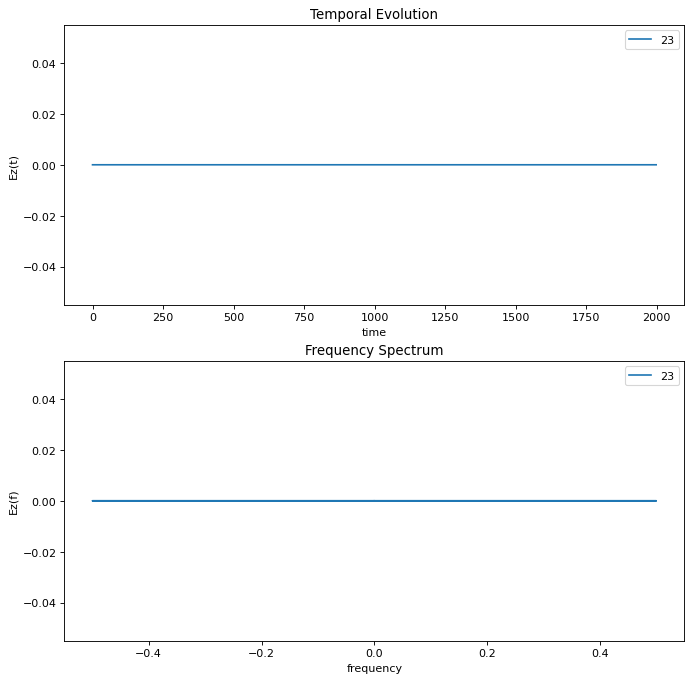

In [80]:
import pandas as pd
Ez = np.zeros((1999,200))
yf = np.zeros((1999,200))
N = 1999
T = 1
xf = fftfreq(N,T)

for ii in range(N_seg):

    filename = f"ez_tab_{ii:04d}.csv"
    df = pd.read_csv(filename)
    # print(df.shape)
    Ez[:,ii] = df.iloc[:,100]      #all time stamps of the 100th spatial index
    # Ez[:,ii] -= np.mean(Ez[:,ii])
    
    yf[:,ii] = abs(fft(Ez[:,ii]))
    
    #accessing particular columns - all elements(all time steps for a particular spatial coordinate.)
x = range(len(df.iloc[0,:])) 
print(x)   

for ii in range(N_seg):
    figure(figsize=(10, 10), dpi=80)
    plt.subplot(2,1,1)
    plt.plot(Ez[:,ii], label={ii})
    plt.title("Temporal Evolution")
    plt.xlabel("time")
    plt.ylabel("Ez(t)")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(xf,yf[:,ii], label={ii})
    plt.title("Frequency Spectrum")
    plt.xlabel("frequency")
    plt.ylabel("Ez(f)")
    plt.legend()
    plt.show()
